In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
dataframe = pd.read_csv(r'C:\Users\vishn\Downloads\REHS\Post_WEKA\Ouput (476) Data.csv')
dataframe['Name'] = dataframe['Name'].replace({'Selected': 1, 'Random': 0})
dataset = dataframe.values
X = dataset[:,0:-1].astype(float)
Y = dataset[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=1)
print(x_train.shape)
y_train.shape

(204, 476)


(204,)

In [4]:
def model_builder(hp):
  #model = keras.Sequential()
  inputs = keras.Input(shape=(476,))
  x = inputs

  for i in range(hp.Int("mlplayers", 2, 8)):

      x = keras.layers.Dense(
          units=hp.Int("units", 32, 512, step=32), activation="relu",
      )(x)
  
  #x = keras.layers.Dropout(hp.Choice('dropout_value', values=[0.0, 0.1, 0.2, 0.3]))(x)
  x = keras.layers.Dropout(0.2)(x)

  outputs = keras.layers.Dense(units=1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(
      loss="binary_crossentropy", metrics=["accuracy"], optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
  )

  return model


In [5]:
tuner = kt.Hyperband(
    model_builder,
    overwrite=True,
    factor=3,
    objective="val_accuracy",
    directory="/tmp/tb",
)

stop_early = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [6]:
tuner.search(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    callbacks=[stop_early, keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

Trial 254 Complete [00h 00m 02s]
val_accuracy: 0.9512194991111755

Best val_accuracy So Far: 0.9756097793579102
Total elapsed time: 00h 07m 37s
INFO:tensorflow:Oracle triggered exit


Epoch 1/6
26/26 [==============================] - 1s 10ms/step - loss: 0.4834 - accuracy: 0.8137 - val_loss: 0.5581 - val_accuracy: 0.8654
Epoch 2/6
26/26 [==============================] - 0s 5ms/step - loss: 0.2374 - accuracy: 0.9363 - val_loss: 0.4900 - val_accuracy: 0.9423
Epoch 3/6
26/26 [==============================] - 0s 5ms/step - loss: 0.1947 - accuracy: 0.9412 - val_loss: 0.3658 - val_accuracy: 0.9231
Epoch 4/6
26/26 [==============================] - 0s 5ms/step - loss: 0.1321 - accuracy: 0.9559 - val_loss: 0.3684 - val_accuracy: 0.9038
Epoch 5/6
26/26 [==============================] - 0s 5ms/step - loss: 0.1139 - accuracy: 0.9559 - val_loss: 0.3881 - val_accuracy: 0.8846
Epoch 6/6
26/26 [==============================] - 0s 5ms/step - loss: 0.1228 - accuracy: 0.9510 - val_loss: 0.3739 - val_accuracy: 0.9038


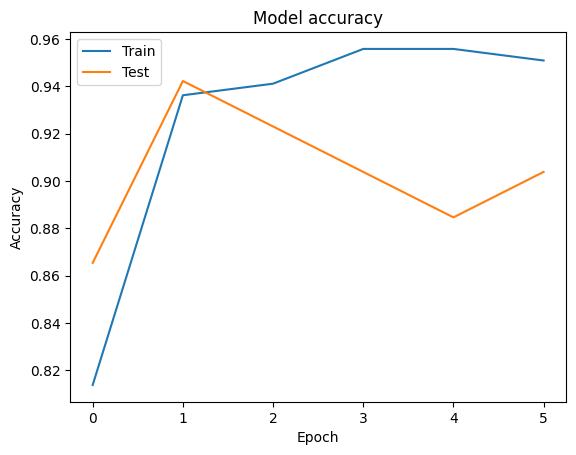

In [7]:
best_hp = tuner.get_best_hyperparameters()[0]
model = model_builder(best_hp)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=6, batch_size=8)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
best_hp = tuner.get_best_hyperparameters()[0]
histories = []
accuracies = []
trials = 5

for trial in range(trials):
    model = model_builder(best_hp)
    history = model.fit(x_train, y_train, epochs=6)
    histories.append(history)
    trial_accuracy = history.history['accuracy']
    if trial == 0:
        total_accuracies = trial_accuracy
    else:
        total_accuracies = np.vstack((total_accuracies, trial_accuracy))


average_accuracy = np.mean(total_accuracies, axis=0)
average_accuracy

Epoch 1/6
7/7 [==============================] - 1s 5ms/step - loss: 0.4846 - accuracy: 0.7304
Epoch 2/6
7/7 [==============================] - 0s 5ms/step - loss: 0.1969 - accuracy: 0.9412
Epoch 3/6
7/7 [==============================] - 0s 5ms/step - loss: 0.1246 - accuracy: 0.9510
Epoch 4/6
7/7 [==============================] - 0s 5ms/step - loss: 0.1085 - accuracy: 0.9510
Epoch 5/6
7/7 [==============================] - 0s 5ms/step - loss: 0.0956 - accuracy: 0.9657
Epoch 6/6
7/7 [==============================] - 0s 5ms/step - loss: 0.0901 - accuracy: 0.9657
Epoch 1/6
7/7 [==============================] - 1s 5ms/step - loss: 0.4634 - accuracy: 0.7353
Epoch 2/6
7/7 [==============================] - 0s 5ms/step - loss: 0.1935 - accuracy: 0.9363
Epoch 3/6
7/7 [==============================] - 0s 5ms/step - loss: 0.1993 - accuracy: 0.9412
Epoch 4/6
7/7 [==============================] - 0s 5ms/step - loss: 0.1200 - accuracy: 0.9461
Epoch 5/6
7/7 [==============================] - 0

array([0.69509803, 0.93137256, 0.9490196 , 0.95588235, 0.96176471,
       0.96372548])

In [8]:
model = model_builder(best_hp) # Using the model_builder function you've defined

# Step 2: Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hp.get('learning_rate')),
              loss="binary_crossentropy", 
              metrics=["accuracy"])

# Step 3: Train the model
history = model.fit(x_train, y_train, epochs=6)

# Step 4: Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Output the accuracy of the model on test data
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/6
7/7 [==============================] - 1s 3ms/step - loss: 0.6524 - accuracy: 0.6078
Epoch 2/6
7/7 [==============================] - 0s 3ms/step - loss: 0.3495 - accuracy: 0.8922
Epoch 3/6
7/7 [==============================] - 0s 3ms/step - loss: 0.2041 - accuracy: 0.9314
Epoch 4/6
7/7 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9412
Epoch 5/6
7/7 [==============================] - 0s 2ms/step - loss: 0.1386 - accuracy: 0.9510
Epoch 6/6
2/2 [==============================] - 0s 3ms/step - loss: 0.5411 - accuracy: 0.8846
Test Loss: 0.5411468148231506
Test Accuracy: 0.8846153616905212


In [ ]:
plt.rcParams['figure.dpi'] = 300

# Set the number of trials
trials = 5

accuracies = np.array([history.history['accuracy'] for history in histories])

# Plot training accuracy vs epoch for all trials
plt.figure(figsize=(8, 6))
for i in range(trials):
    plt.plot(range(1, 7), accuracies[i], label=f'Trial {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Epoch')
plt.legend()
plt.show()

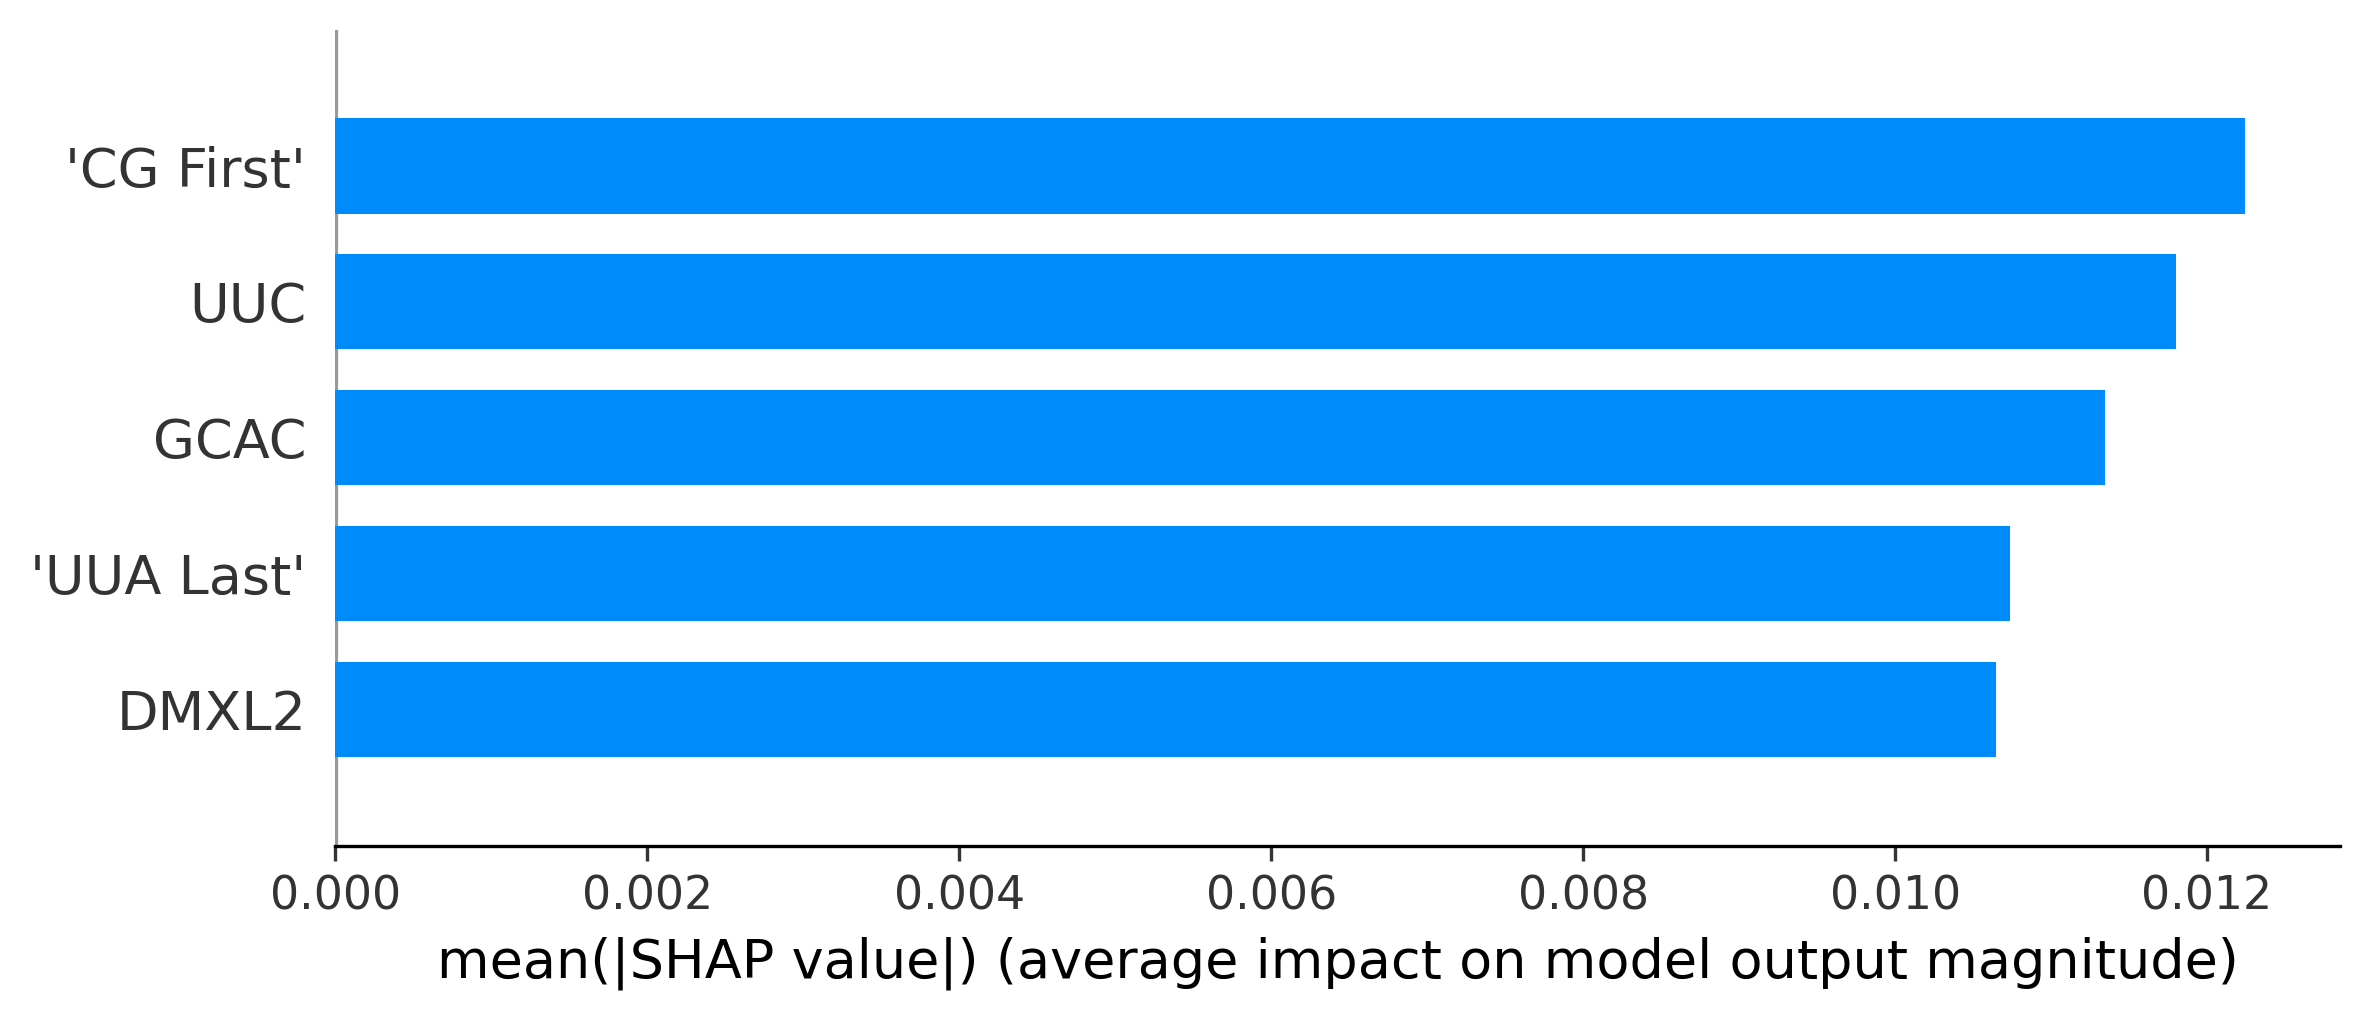

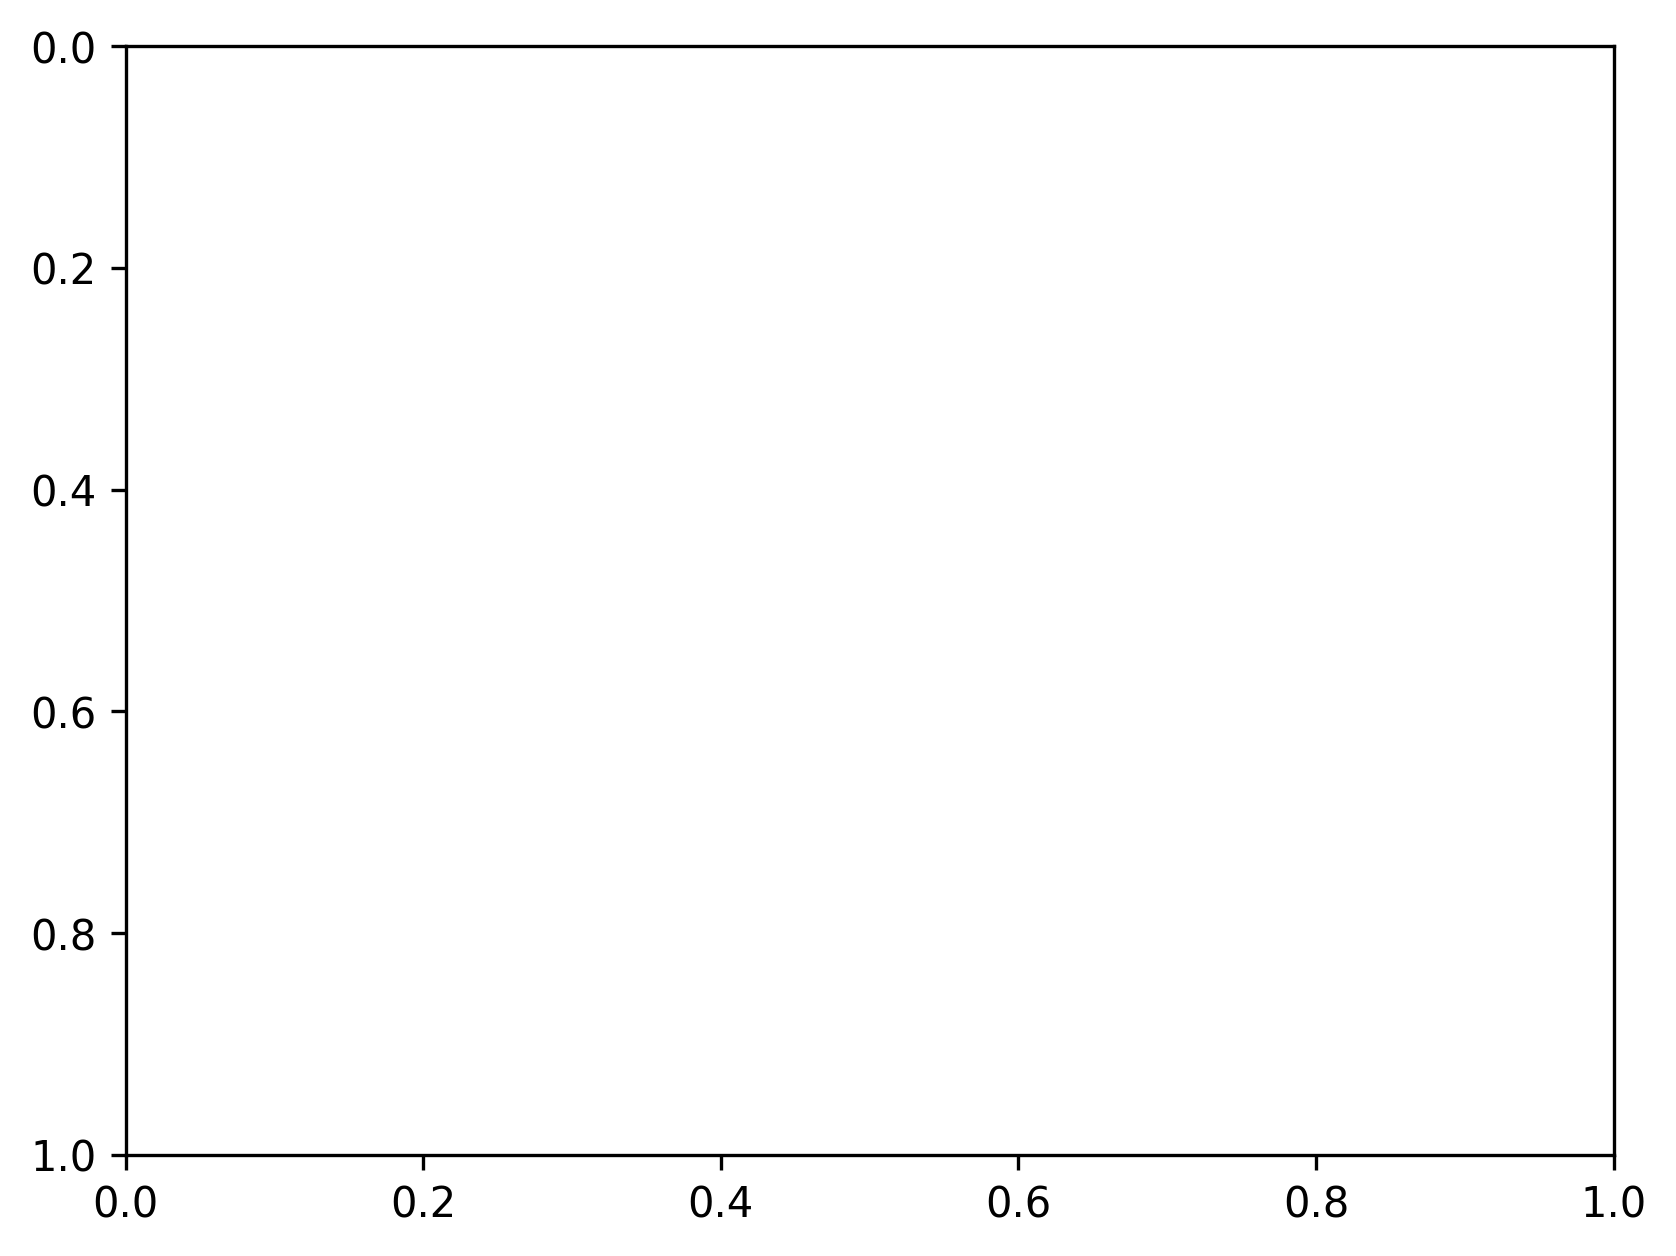

In [18]:
# Assuming dataframe is your original DataFrame and the last column is the target
feature_names = dataframe.columns[:-1]  # Exclude the target variable column

# Now continue with creating the SHAP Explainer
explainer = shap.DeepExplainer(model, x_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(x_test)

# Compute the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values[0]).mean(axis=0)

# Find the indices of the top 5 features based on mean absolute SHAP values
top_features_indices = np.argsort(-mean_abs_shap_values)[:5]

# Get the names of the top 5 features
top_features_names = feature_names[top_features_indices]

# Extract SHAP values for the top features
top_shap_values = shap_values[0][:, top_features_indices]

# Extract the feature values for the top features from the test set
# Assuming x_test is a NumPy array, if it's a DataFrame, use x_test.iloc[:, top_features_indices].values
top_feature_values = x_test[:, top_features_indices]

# Plot the SHAP summary for these top features
shap.summary_plot(top_shap_values, features=top_feature_values, feature_names=top_features_names, plot_type="bar")

# Invert the y-axis to display the highest values at the top
plt.gca().invert_yaxis()
plt.show()

In [12]:
dataframe = pd.read_csv(r'C:\Users\vishn\Downloads\REHS\Alt_Test_Data(476) for 99.csv')

selected_rows = [1, 2, 3, 5, 6, 8, 11, 12, 15, 17]

x_test_alt = dataframe.iloc[selected_rows, 1:-1].values
print(x_test_alt.shape)
y_test_alt = np.ones(10)
print(y_test_alt.shape)

# Assuming that negative class is represented by 0
negative_class_mask = y_test == 0

# Get the negative class records
x_test_negative = x_test[negative_class_mask]
print(x_test_negative.shape)
y_test_negative = y_test[negative_class_mask]
print(y_test_negative.shape)

# Concatenate the negative class records with the alternative test set
x_test_combined = np.concatenate((x_test_alt, x_test_negative[0:10]), axis=0)
print(x_test_combined.shape)
y_test_combined = np.concatenate((y_test_alt, y_test_negative[0:10]), axis=0)
print(y_test_combined.shape)

(10, 476)
(10,)
(29, 476)
(29,)
(20, 476)
(20,)


In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from numpy import mean

histories = []
test_accuracies = []
test_losses = []
trials = 10
best_hp = tuner.get_best_hyperparameters()[0]
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="/tmp/tb_logs")
auroc_scores = []
mcc_scores = []
f1_scores = []
confusion_matrices = []


for trial in range(trials):
    model = model_builder(best_hp)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hp.get('learning_rate')),
              loss="binary_crossentropy", 
              metrics=["accuracy"])
    history = model.fit(x_train, y_train, epochs=15, callbacks=[tensorboard_callback])
    histories.append(history)
    trial_accuracy = history.history['accuracy']
    if trial == 0:
        total_accuracies = trial_accuracy
    else:
        total_accuracies = np.vstack((total_accuracies, trial_accuracy))
    
    y_pred_proba = model.predict(x_test_combined)
    roc_auc = roc_auc_score(y_test_combined, y_pred_proba)
    auroc_scores.append(roc_auc)

    y_pred_int = (y_pred_proba > 0.5).astype(int)
    confusion_matrix_trial = confusion_matrix(y_test_combined, y_pred_int)
    confusion_matrices.append(confusion_matrix_trial)



    test_loss, test_accuracy = model.evaluate(x_test_combined, y_test_combined)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


    f1 = f1_score(y_test_combined, y_pred_int)
    f1_scores.append(f1)
    mcc = matthews_corrcoef(y_test_combined, y_pred_int)
    mcc_scores.append(mcc)

average_accuracy = np.mean(total_accuracies, axis=0)

test_accuracies.append(mean(test_accuracies))
test_losses.append(mean(test_losses))
auroc_scores.append(mean(auroc_scores))
mcc_scores.append(mean(mcc_scores))
f1_scores.append(mean(f1_scores))

Epoch 1/15
7/7 [==============================] - 1s 2ms/step - loss: 0.6220 - accuracy: 0.4951
Epoch 2/15
7/7 [==============================] - 0s 2ms/step - loss: 0.4243 - accuracy: 0.9216
Epoch 3/15
7/7 [==============================] - 0s 2ms/step - loss: 0.2703 - accuracy: 0.9412
Epoch 4/15
7/7 [==============================] - 0s 2ms/step - loss: 0.1587 - accuracy: 0.9559
Epoch 5/15
7/7 [==============================] - 0s 2ms/step - loss: 0.1851 - accuracy: 0.9265
Epoch 6/15
7/7 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.9559
Epoch 7/15
7/7 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.9608
Epoch 8/15
7/7 [==============================] - 0s 2ms/step - loss: 0.1072 - accuracy: 0.9657
Epoch 9/15
7/7 [==============================] - 0s 2ms/step - loss: 0.0981 - accuracy: 0.9657
Epoch 10/15
7/7 [==============================] - 0s 2ms/step - loss: 0.0895 - accuracy: 0.9657
Epoch 11/15
7/7 [======================

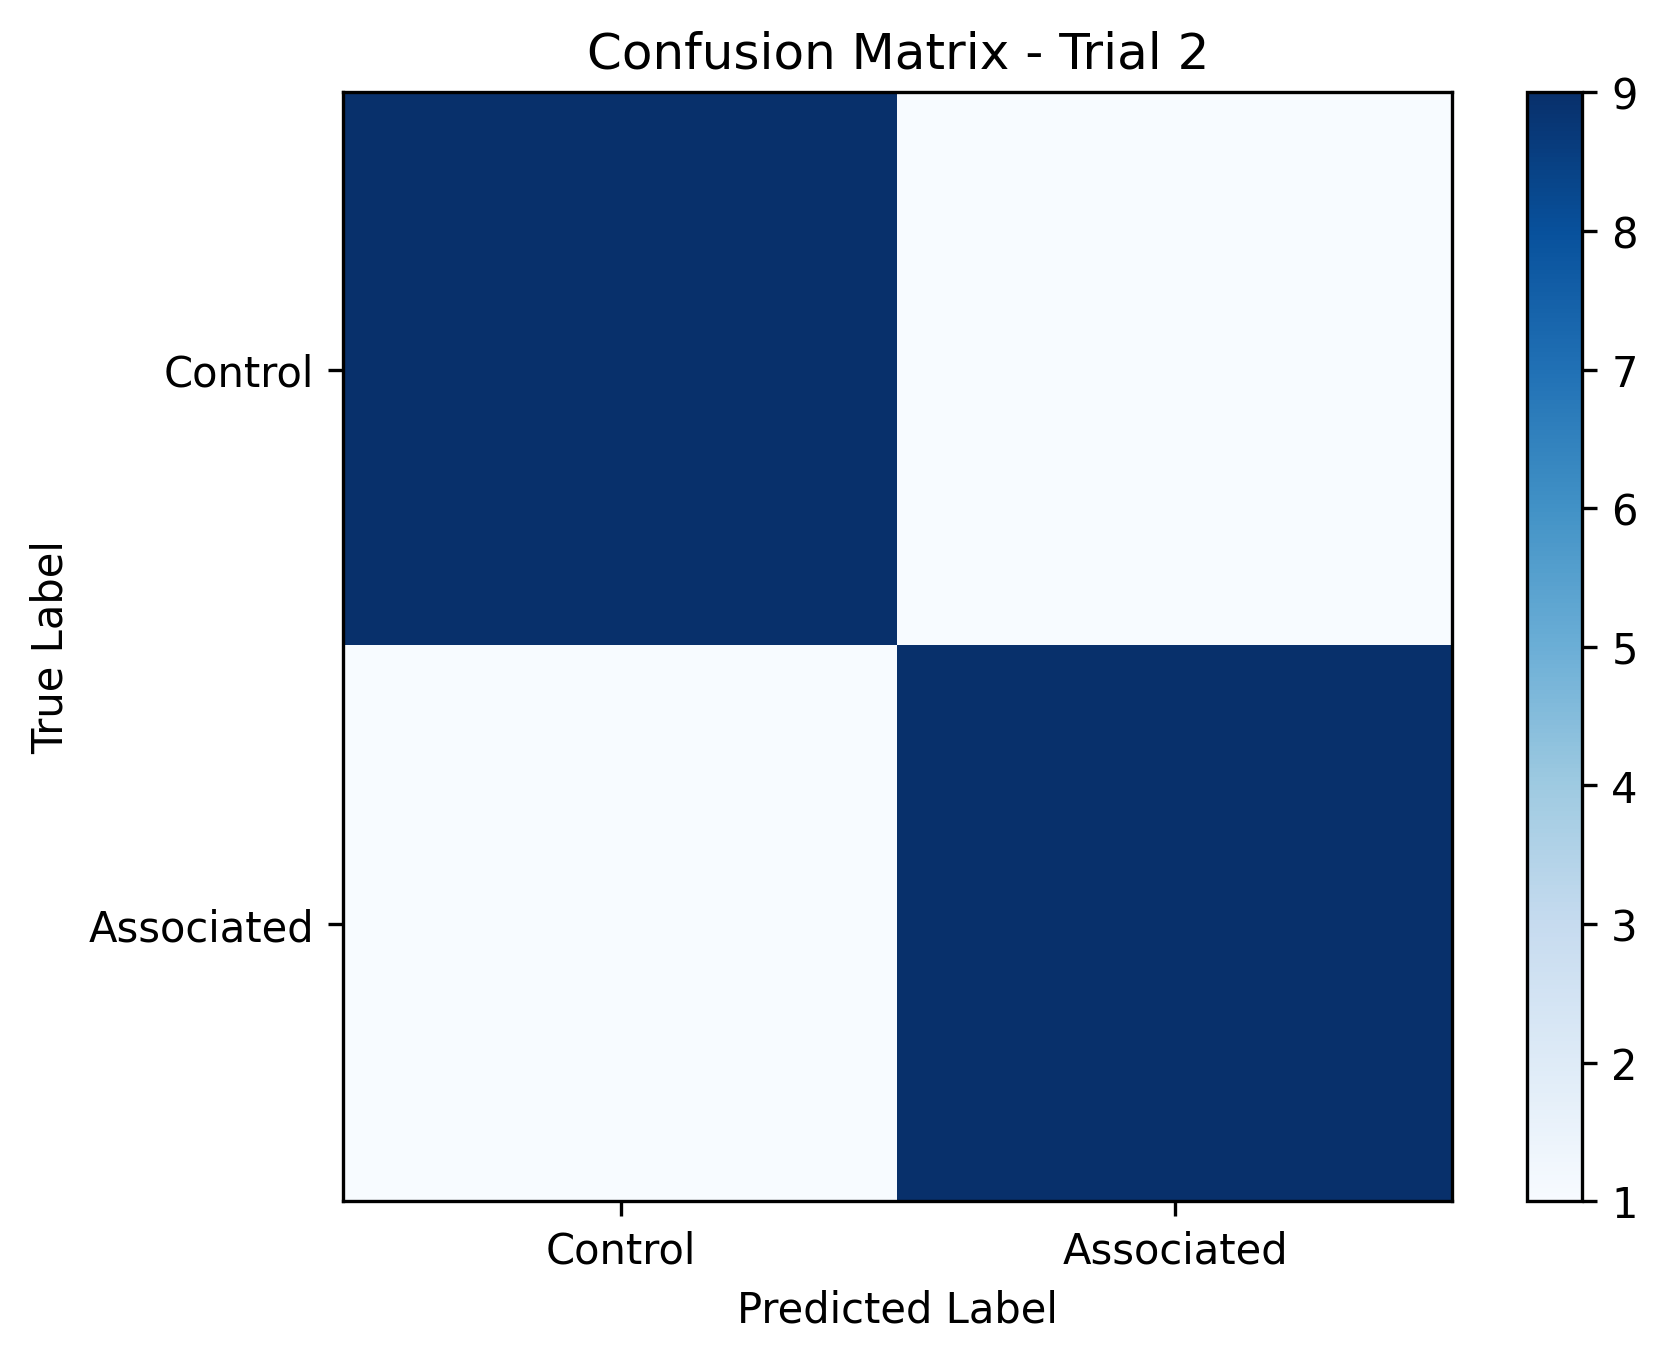

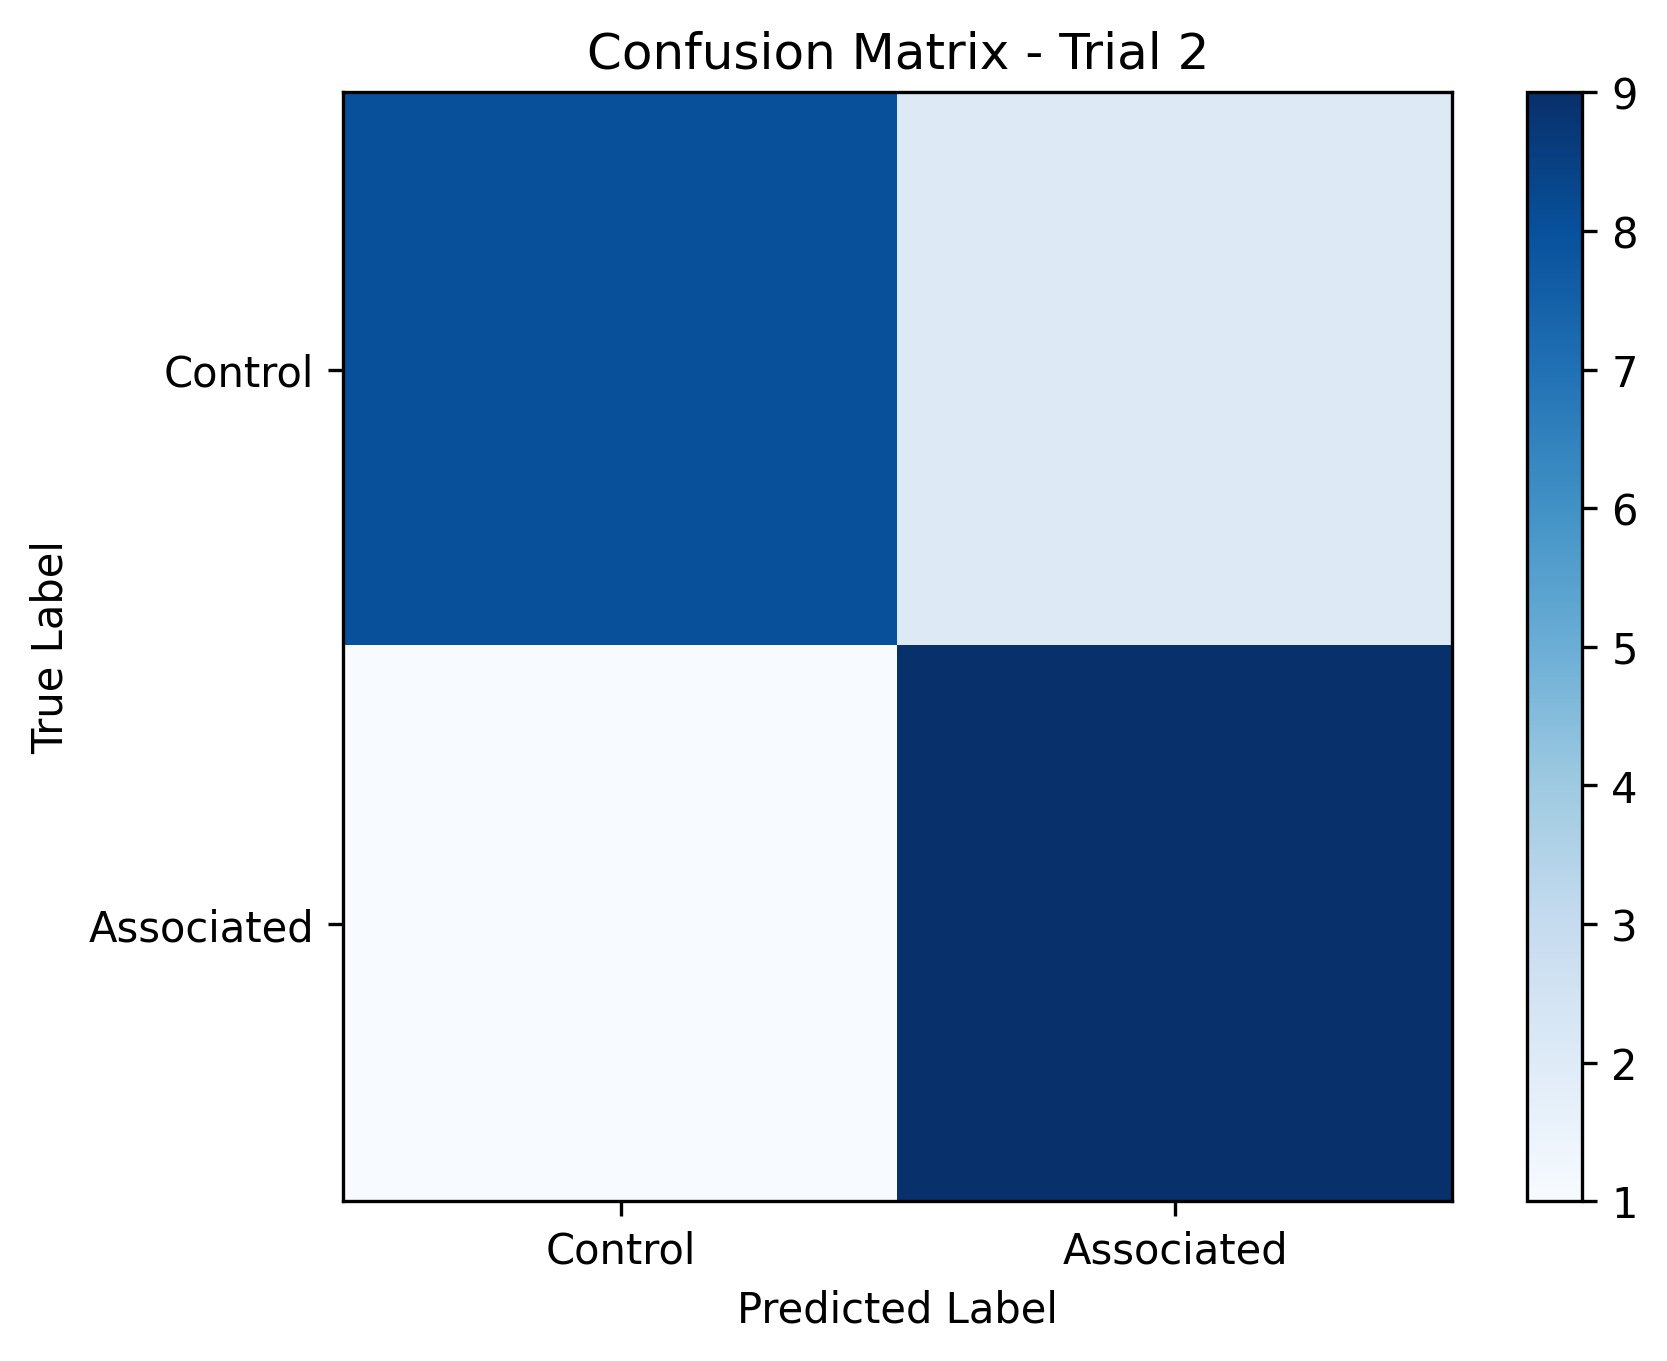

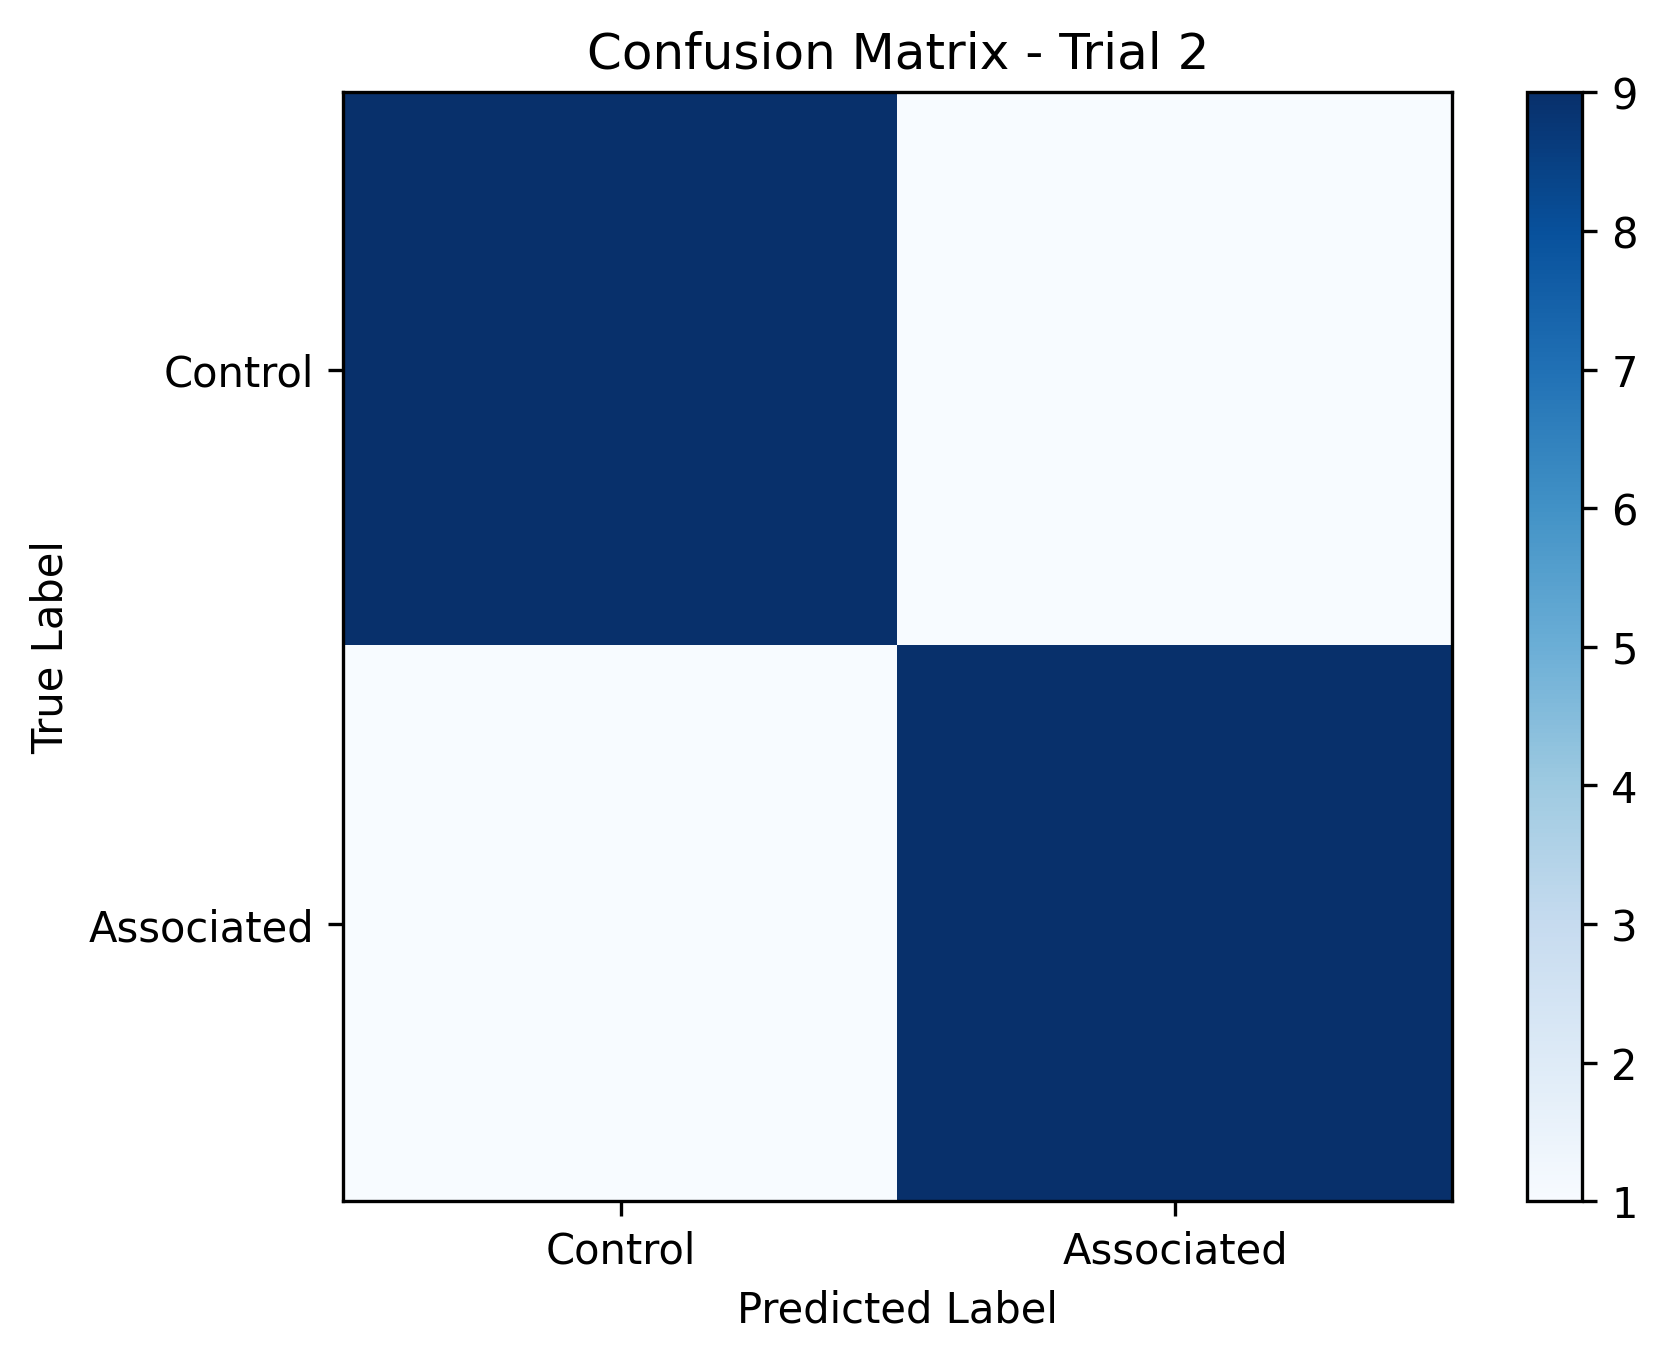

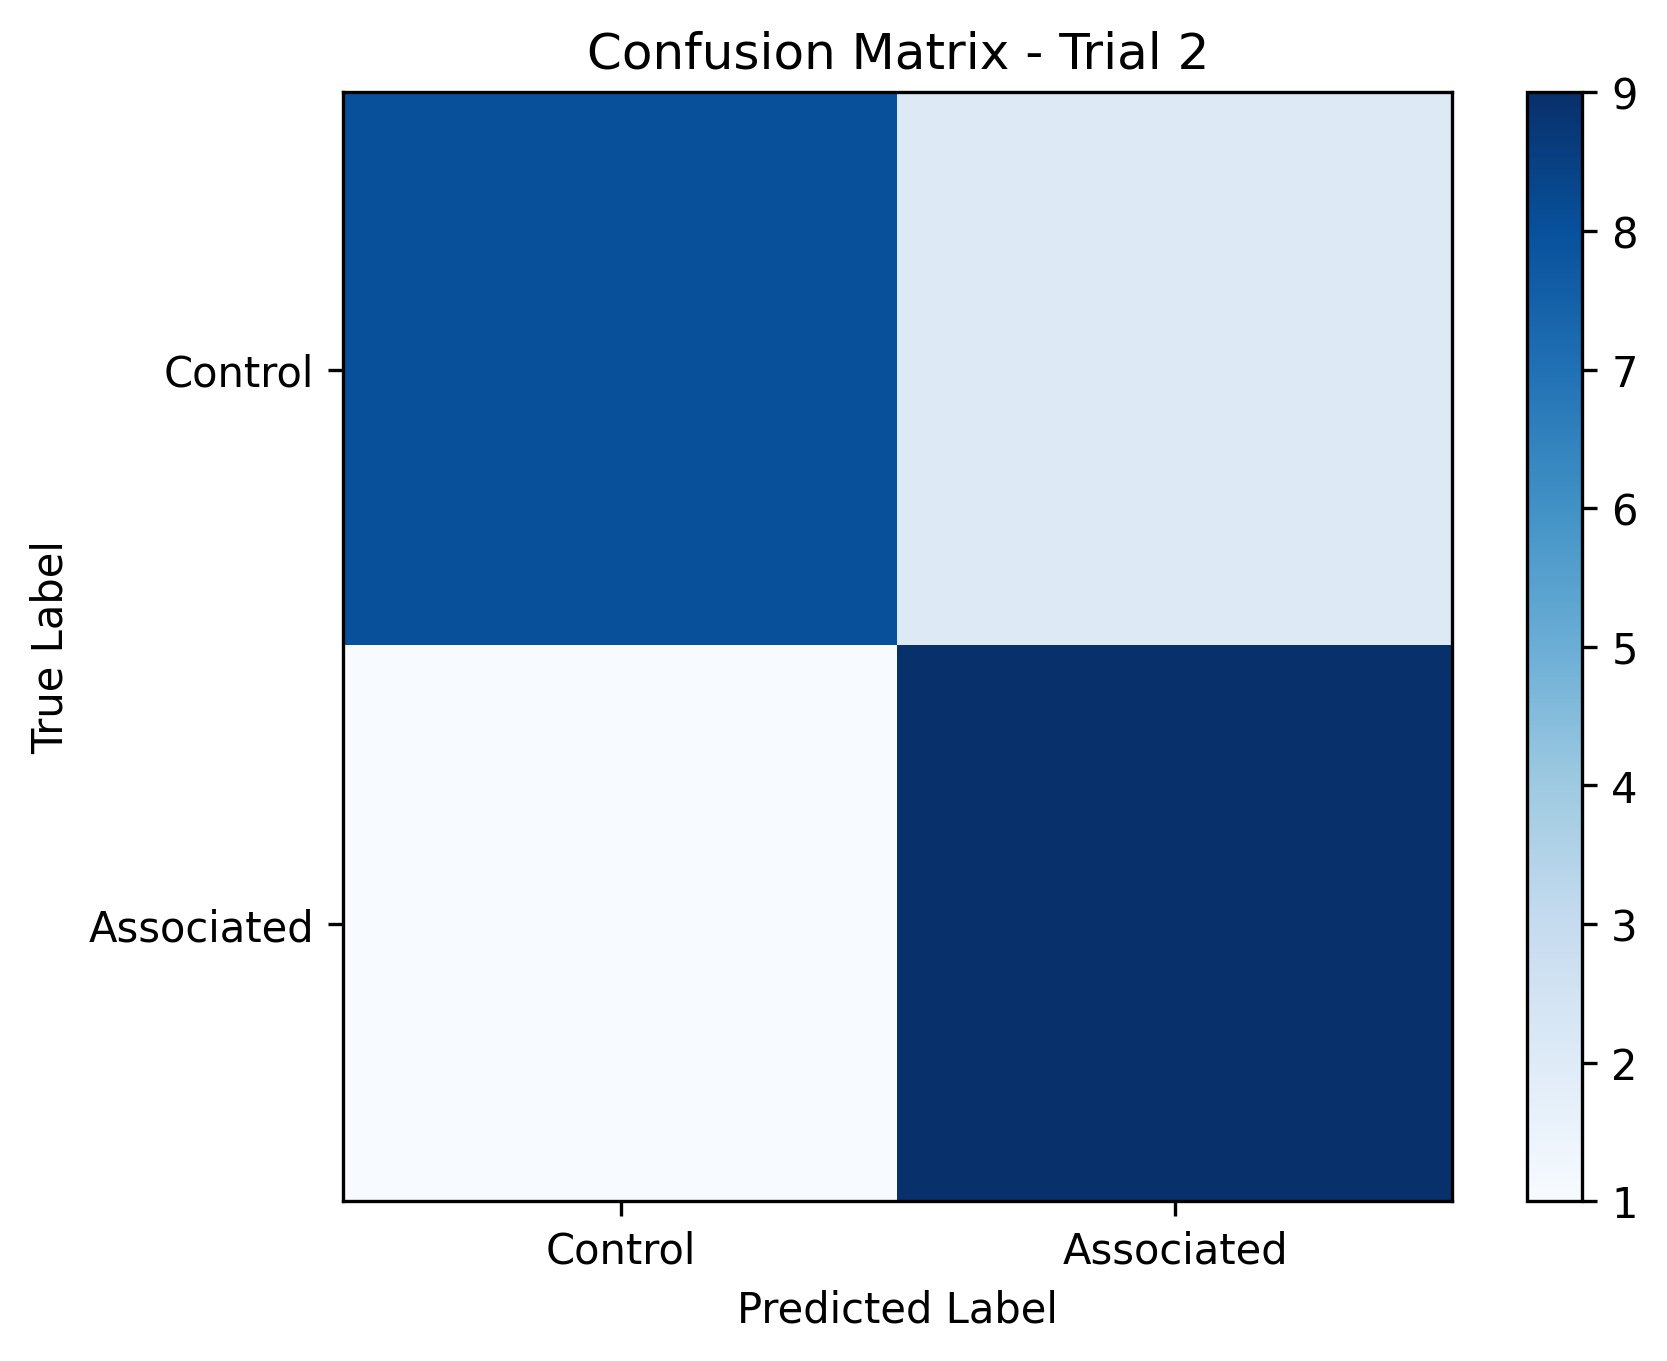

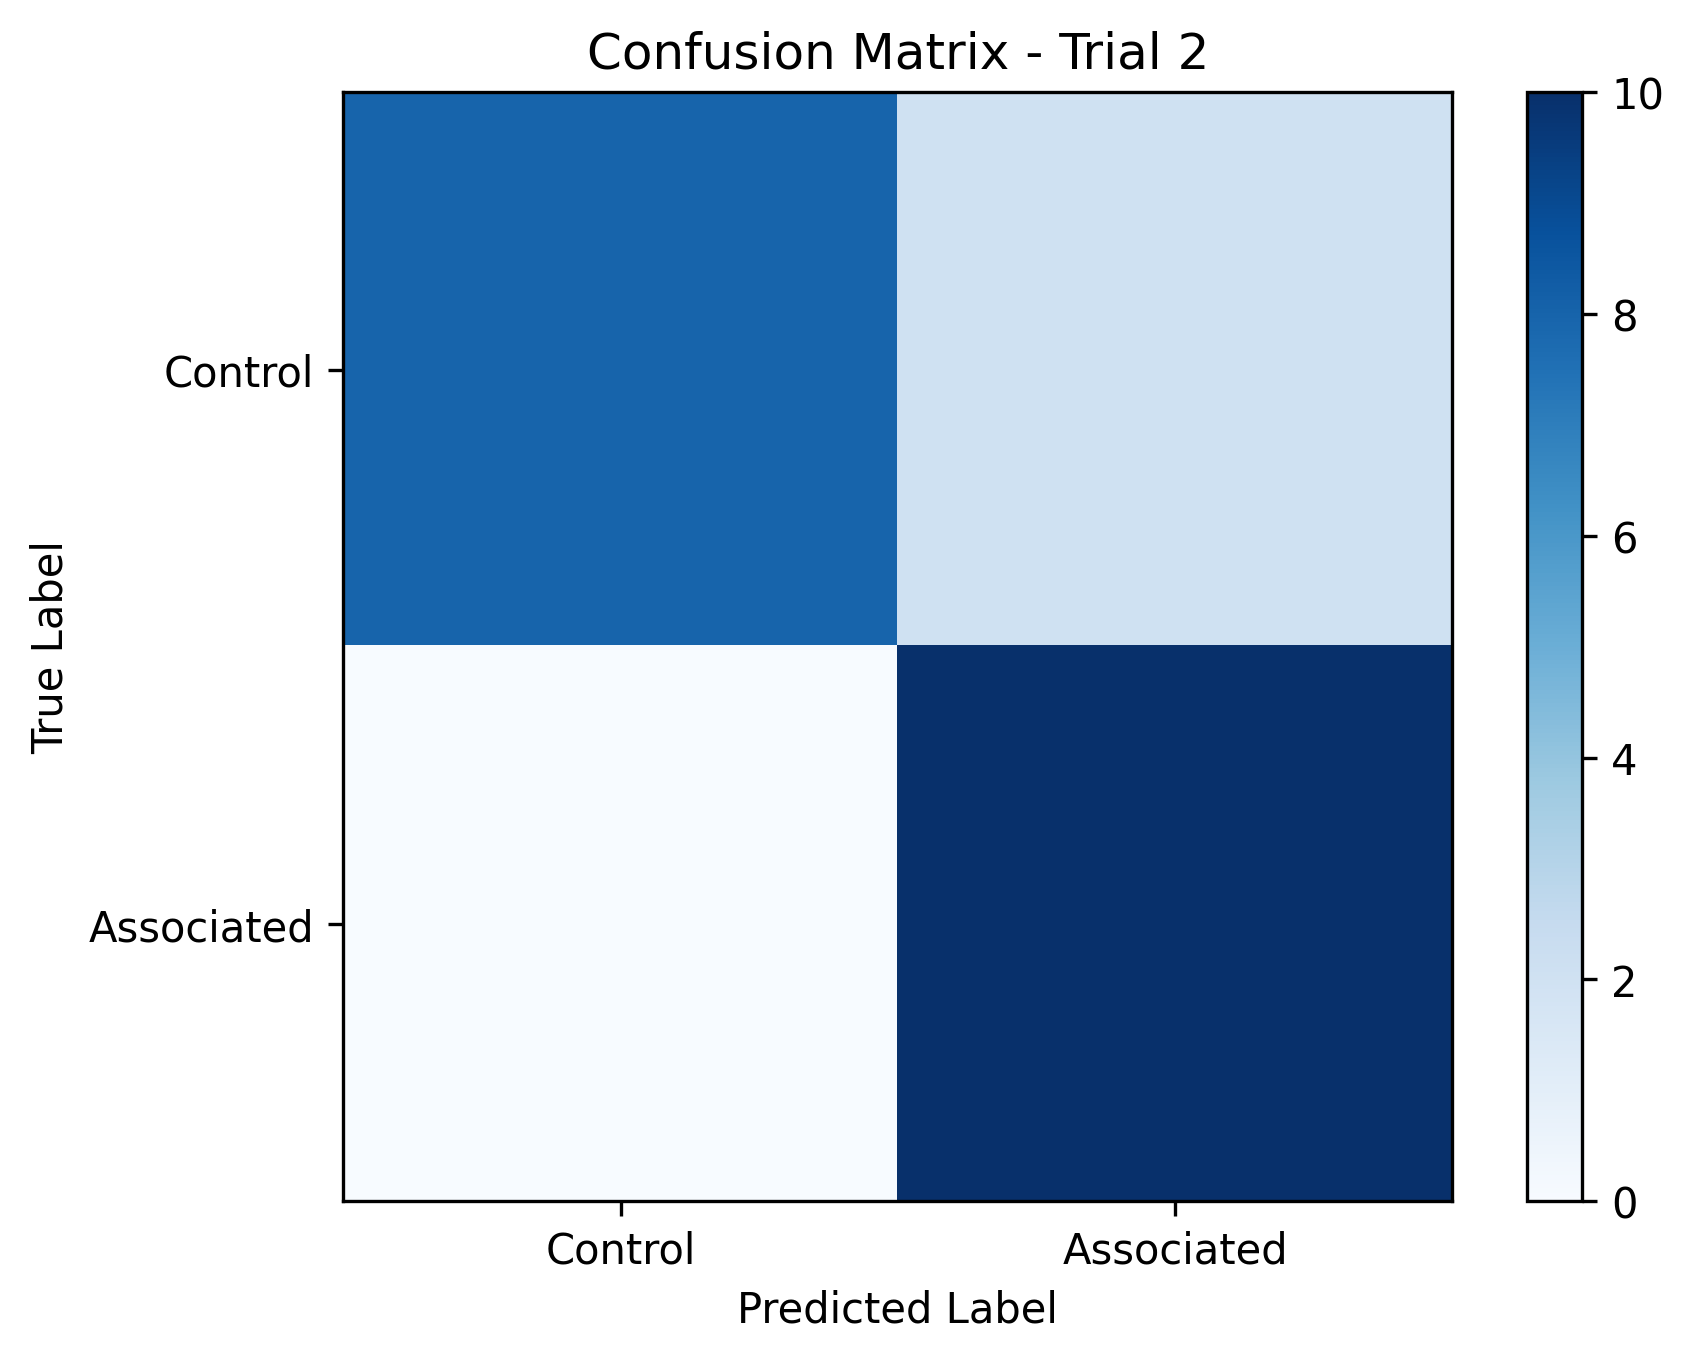

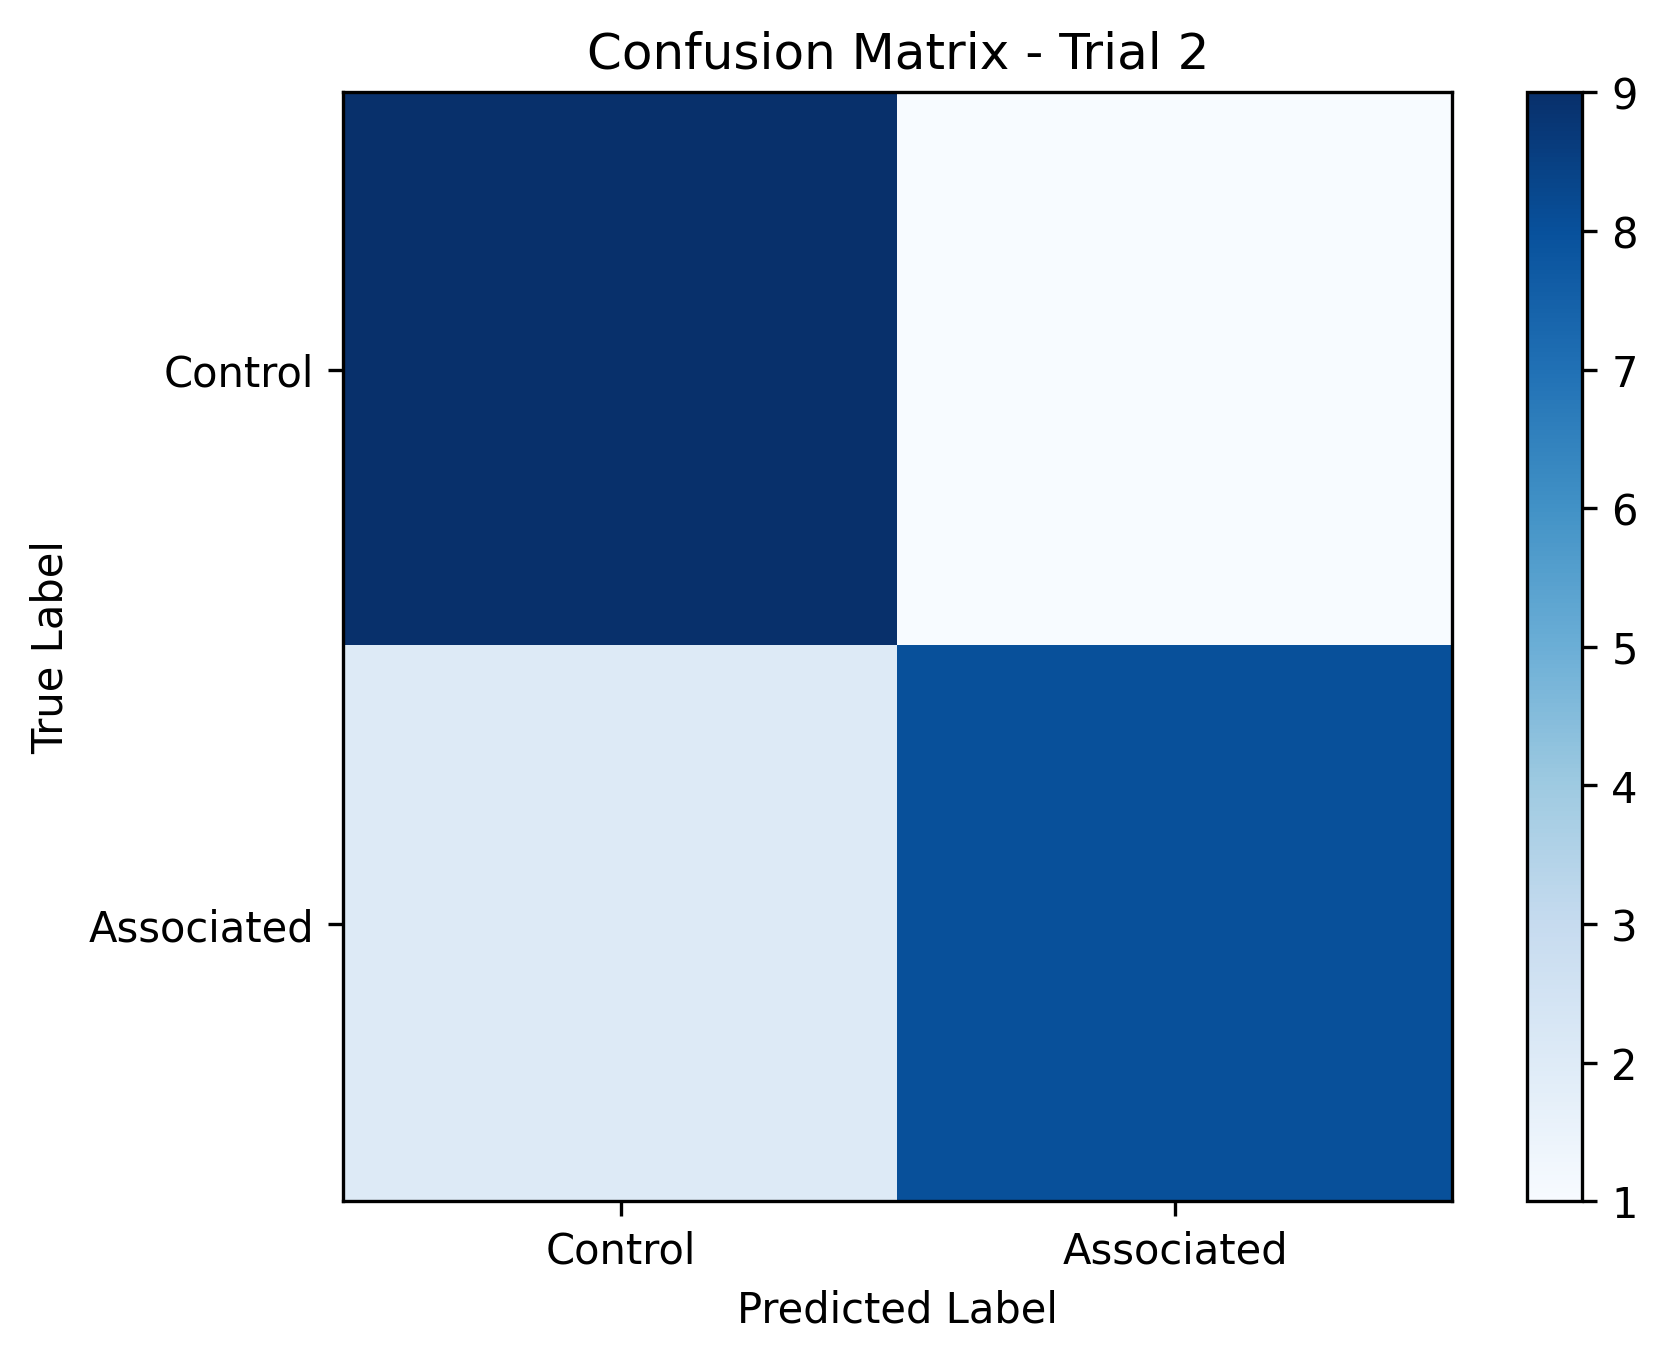

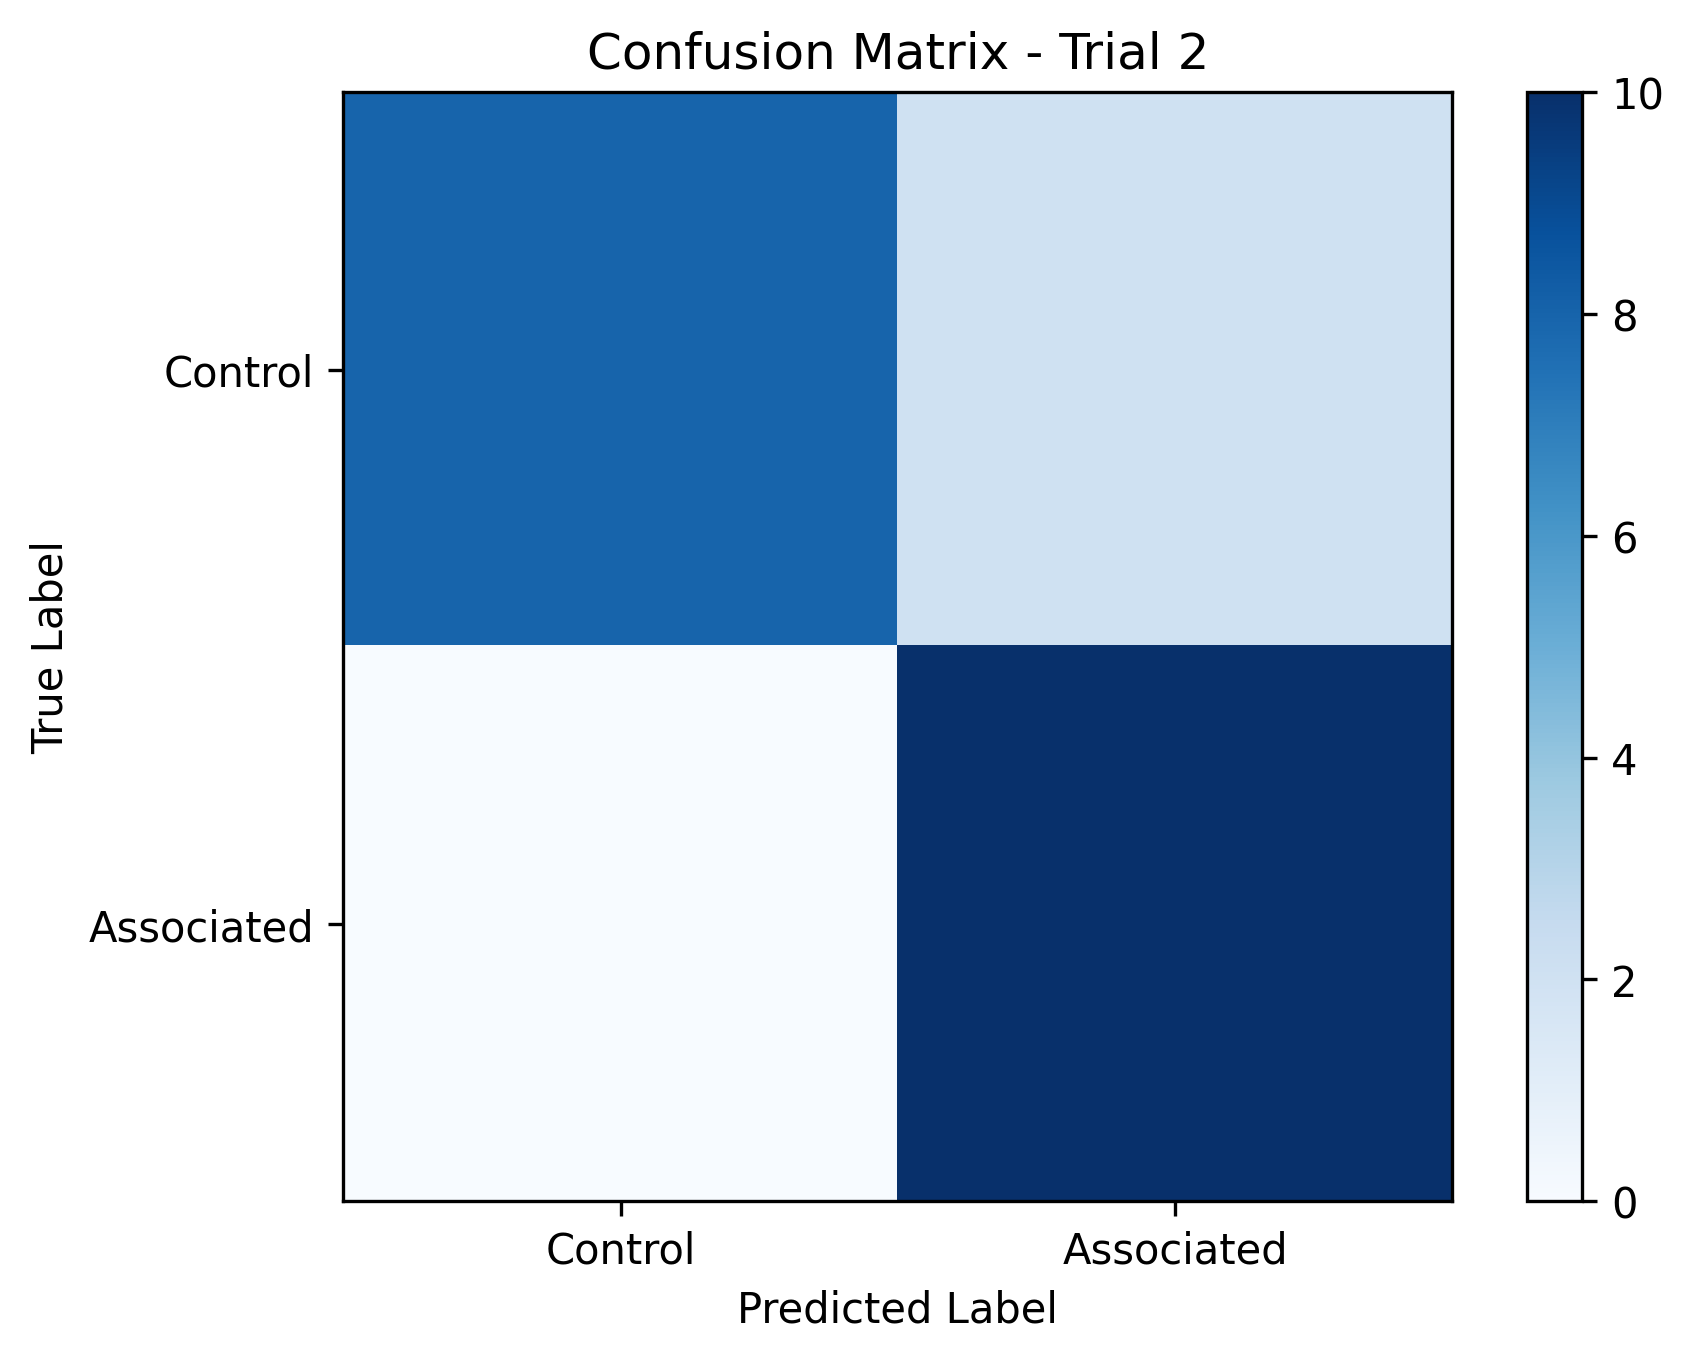

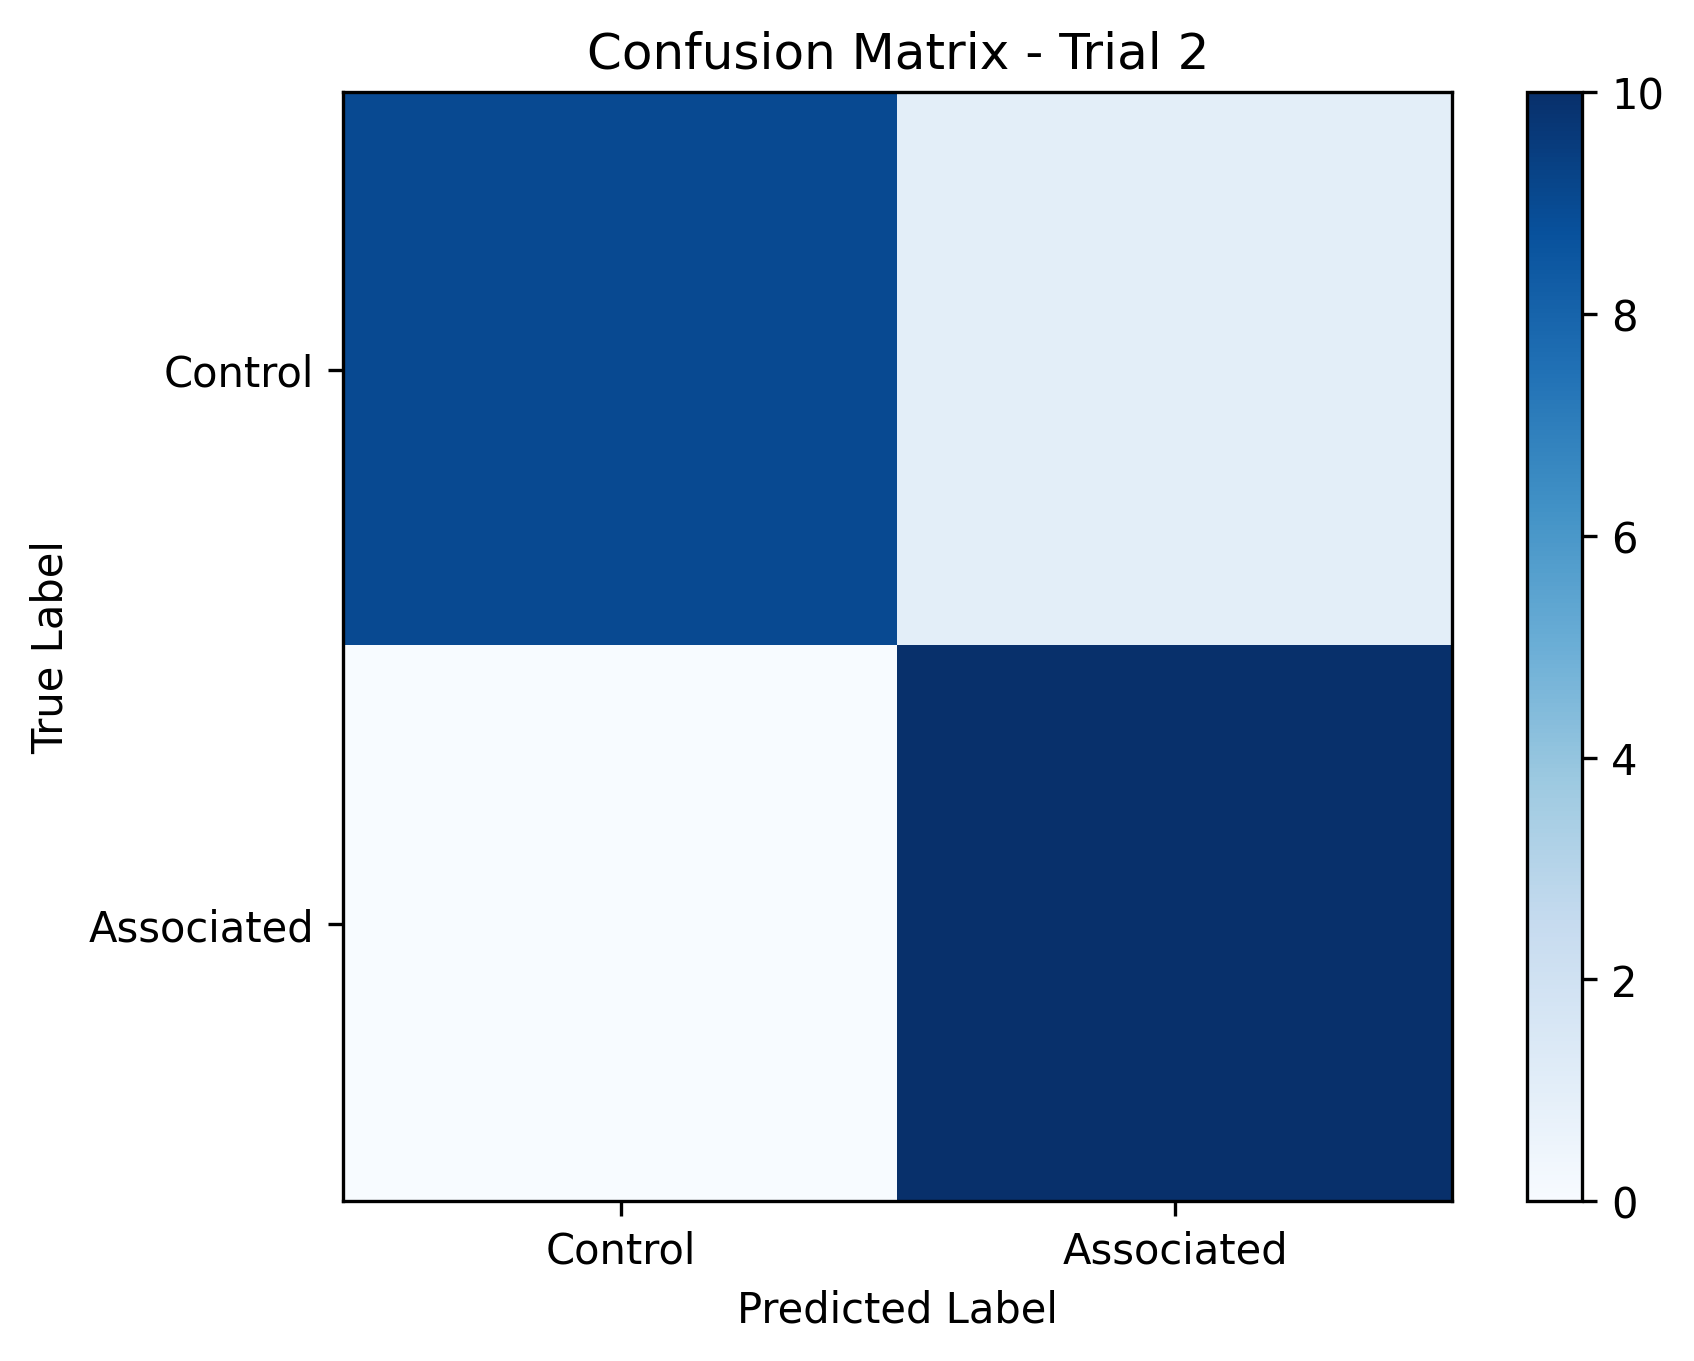

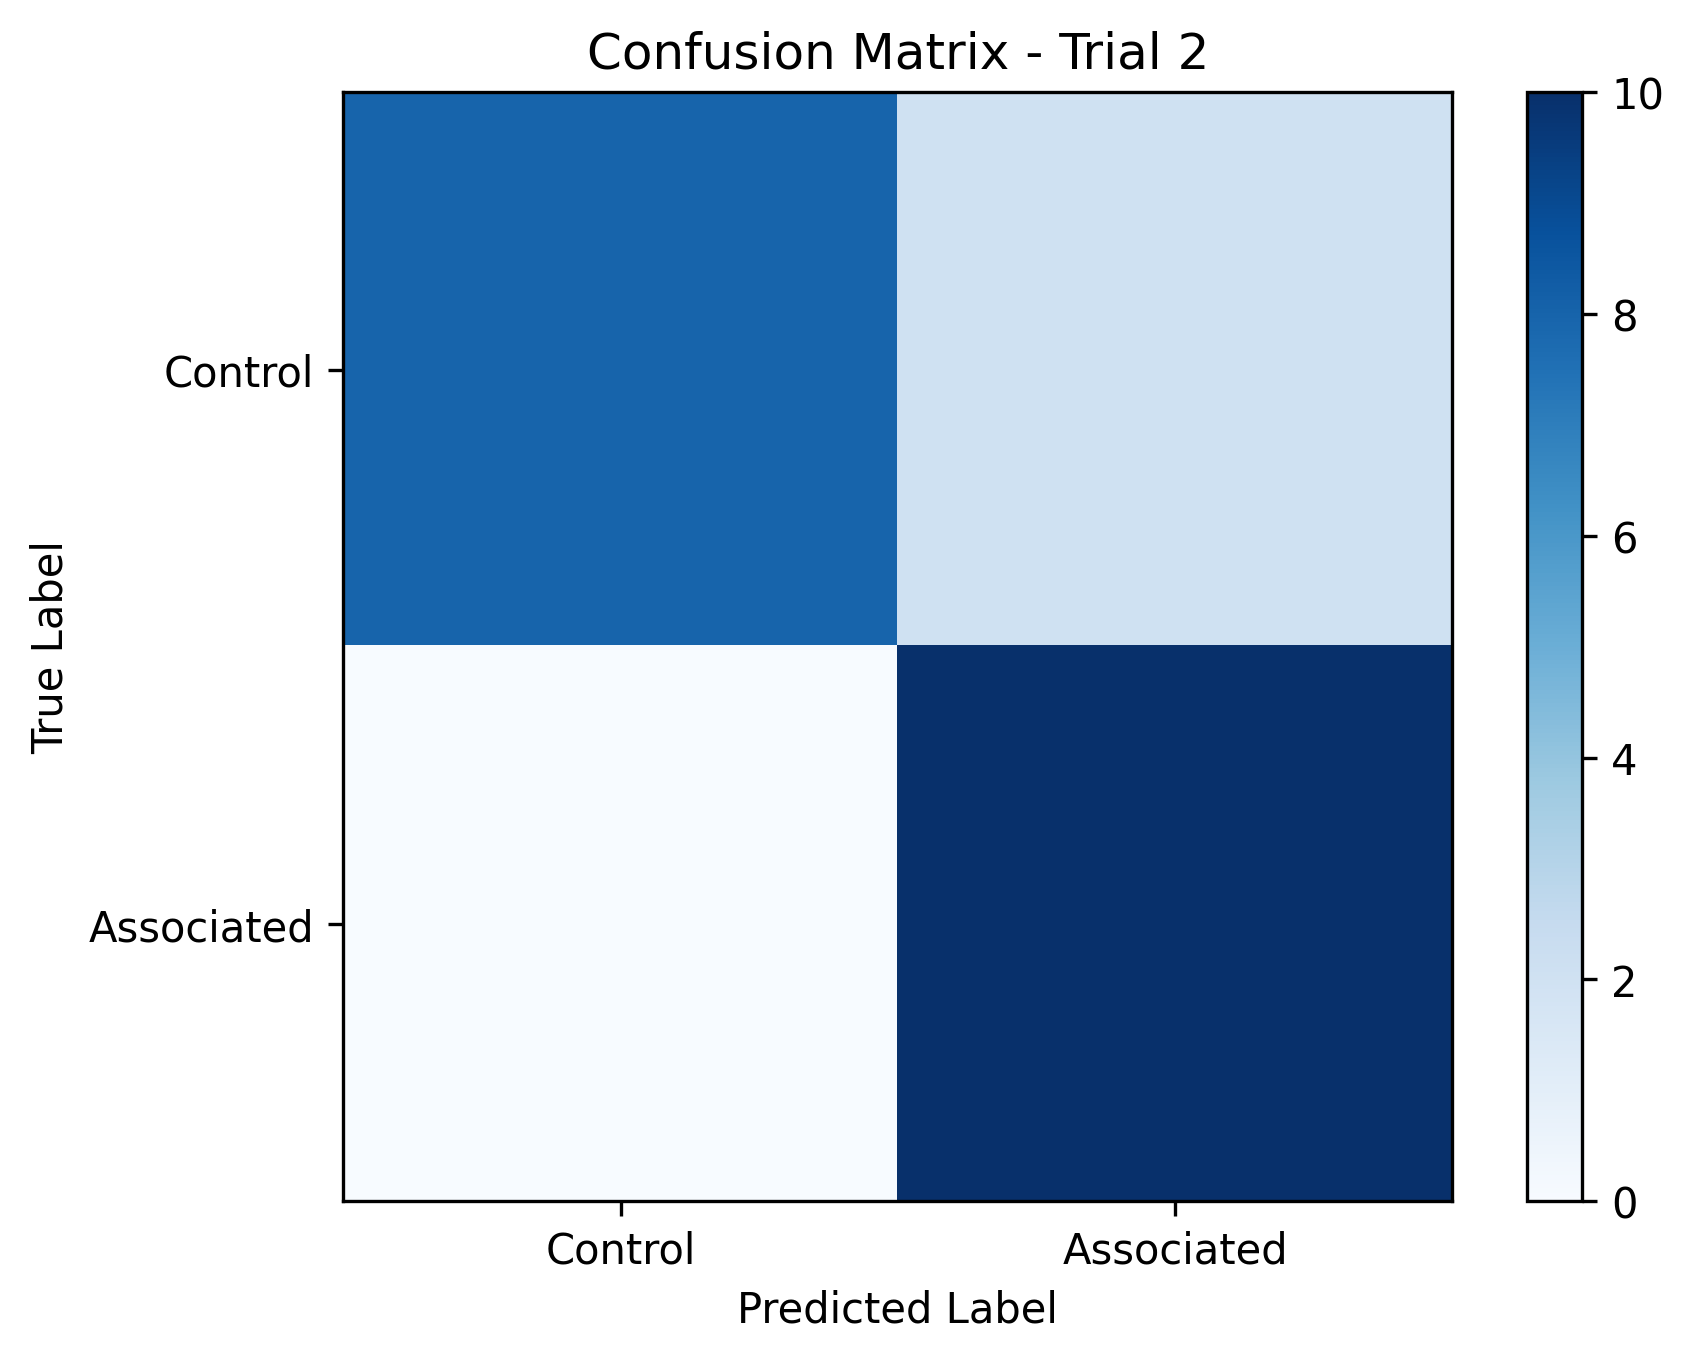

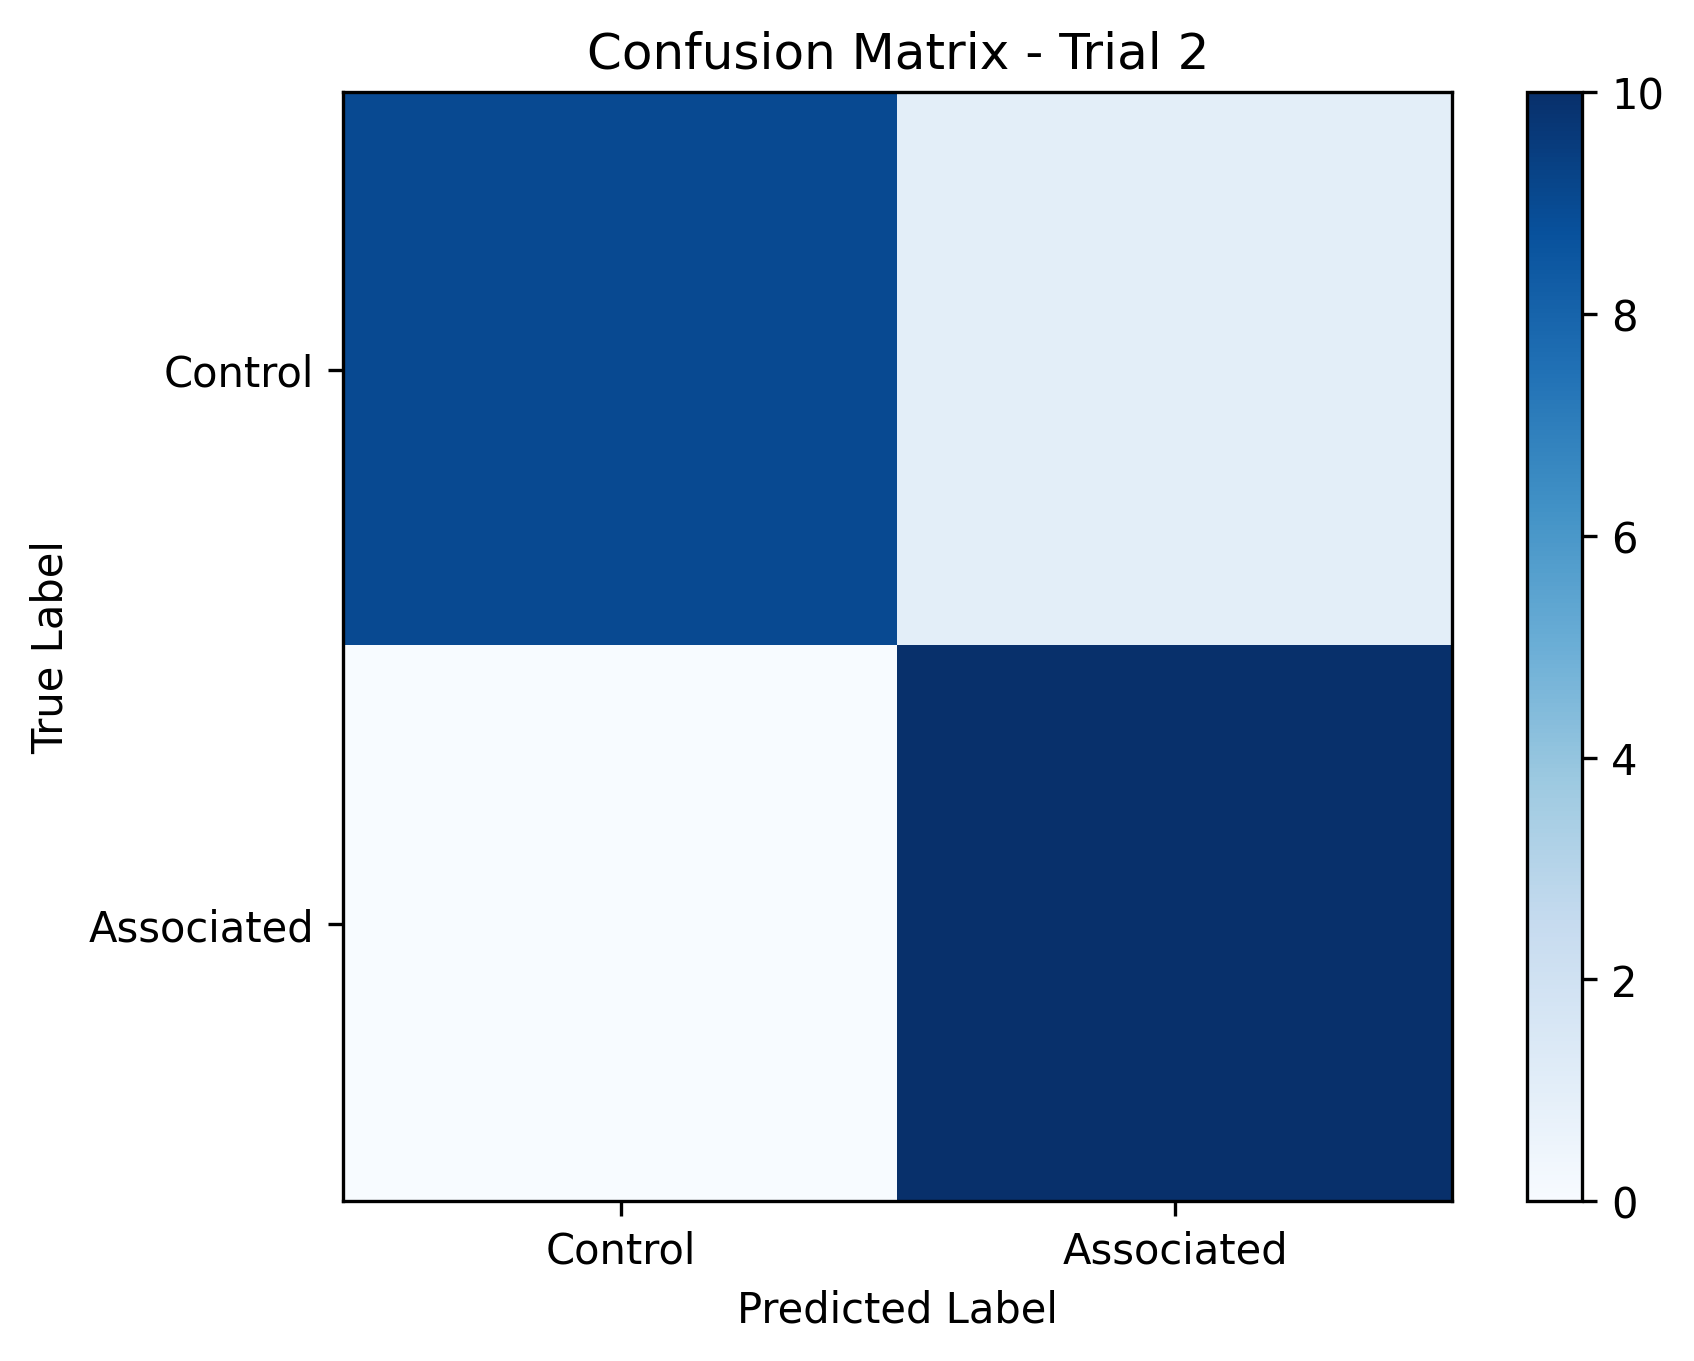

In [29]:
from tabulate import tabulate

for i, cm in enumerate(confusion_matrices):
    plt.figure()
    class_labels = ['Control', 'Associated']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - Trial 2")
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [21]:
test_accuracies

[0.8999999761581421,
 0.8500000238418579,
 0.8999999761581421,
 0.8500000238418579,
 0.8999999761581421,
 0.8500000238418579,
 0.8999999761581421,
 0.949999988079071,
 0.8999999761581421,
 0.949999988079071,
 0.8949999928474426]

In [30]:
auroc_scores

[0.89, 0.89, 0.9, 0.89, 0.8300000000000001, 0.89, 0.9, 0.9, 0.9, 0.9, 0.889]

In [31]:
mcc_scores

[0.8,
 0.7035264706814485,
 0.8,
 0.7035264706814485,
 0.816496580927726,
 0.7035264706814485,
 0.816496580927726,
 0.9045340337332909,
 0.816496580927726,
 0.9045340337332909,
 0.7969137222294106]